# Fisher Kernel
## Objective
1. Given FIM's eigenvectors $u_i$ and correcponding eigenvalues $\lambda_i$, is it true that there always exists eigenvector $u$ with same direction to $d \mu$?
  - Probably
2. Visualize the transition from sample space to parameter space with kernel method.
  - Checked
3. In logistic regression model, what is phi in the fisher score mapping?

## Create Sample Models and Data

In [180]:
# Code by Dohoon Kim

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device = 'cpu'  # Using CPU instead of GPU

class LogisticRegression1(torch.nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression1, self).__init__()
        self.w = torch.randn([1, input_dim], dtype=torch.float64, requires_grad=True)
        self.b = torch.randn([1, 1], dtype=torch.float64, requires_grad=True)

    def get_loss(self, data, labels):
        fs = self.forward(data)
        loss_val = torch.sum(-labels * torch.log(fs) - (1 - labels) * torch.log(1 - fs))
        return loss_val

    def forward(self, x):
        outputs = torch.sigmoid(torch.matmul(self.w, x.T) + self.b)
        return outputs

class LogisticRegression2(torch.nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression2, self).__init__()
        self.w = torch.randn([1, input_dim], dtype=torch.float64, requires_grad=True)
        self.mu = torch.randn([1, input_dim], dtype=torch.float64, requires_grad=True)

    def get_loss(self, data, labels):
        fs = self.forward(data)
        loss_val = torch.sum(-labels * torch.log(fs) - (1 - labels) * torch.log(1 - fs))
        return loss_val

    def forward(self, x):
        outputs = torch.sigmoid(torch.matmul(self.w, (x - self.mu).T))
        return outputs

def train_model1(model, data, labels, num_update=1000, step_size=0.01):
    optimizer = torch.optim.SGD([model.w, model.b], lr=step_size)
    for i in range(num_update):
        cost = model.get_loss(data, labels)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    return model.w.detach(), model.b.detach()

def train_model2(model, data, labels, num_update=1000, step_size=0.01):
    optimizer = torch.optim.SGD([model.w, model.mu], lr=step_size)
    for i in range(num_update):
        cost = model.get_loss(data, labels)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    return model.w.detach(), model.mu.detach()

# 평행한 데이터 생성 함수
def generate_designed_data(n_samples, input_dim, shift):
    # y = x 선 위의 점들 생성
    x = torch.linspace(-10, 10, n_samples, dtype=torch.float64)
    y = x

    # 클래스 1: -x 방향으로 평행 이동
    data1 = torch.stack([x - shift, y], dim=1)
    labels1 = torch.ones(n_samples, dtype=torch.float64)

    # 클래스 2: +x 방향으로 평행 이동
    data2 = torch.stack([x + shift, y], dim=1)
    labels2 = torch.zeros(n_samples, dtype=torch.float64)

    # 데이터와 레이블 결합
    data = torch.cat((data1, data2), dim=0)
    labels = torch.cat((labels1, labels2), dim=0)

    return data, labels


def generate_dense_triangular_data(n_samples, shift):
    # Class 1: points in the left upper triangle
    x1 = torch.empty(n_samples, dtype=torch.float64).uniform_(-5,5)
    y1 = torch.empty(n_samples, dtype=torch.float64).uniform_(-5, 5)
    mask1 = y1 > -x1
    data1 = torch.stack([x1[mask1]+shift, y1[mask1]], dim=1)
    labels1 = torch.ones(len(data1), dtype=torch.float64)

    # Class 2: points in the right lower triangle
    x2 = torch.empty(n_samples, dtype=torch.float64).uniform_(-5,5)
    y2 = torch.empty(n_samples, dtype=torch.float64).uniform_(-5,5)
    mask2 = y2 < -x2
    data2 = torch.stack([x2[mask2]-shift, y2[mask2]], dim=1)
    labels2 = torch.zeros(len(data2), dtype=torch.float64)

    # Combine data and labels
    data = torch.cat((data1, data2), dim=0)
    labels = torch.cat((labels1, labels2), dim=0)

    return data, labels

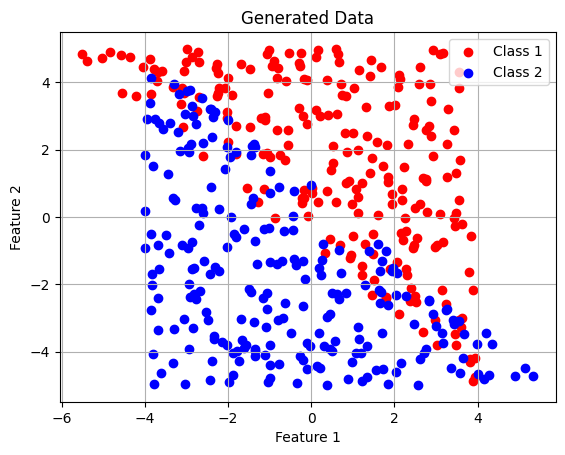

In [181]:
# Code by Dohoon Kim

# 두 모델에서 w가 같도록 데이터 설계
dim = 2
n_samples_per_class = 500
shift = -1

# 데이터 생성
#data, labels = generate_designed_data(n_samples_per_class, dim, shift)

data, labels = generate_dense_triangular_data(n_samples_per_class, shift)

# 데이터 시각화
data1 = data[labels == 1]
data2 = data[labels == 0]

# Plot the data
plt.scatter(data1[:, 0], data1[:, 1], c='red', label='Class 1')
plt.scatter(data2[:, 0], data2[:, 1], c='blue', label='Class 2')
plt.title('Generated Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid()
plt.show()

In [182]:
# Code by Dohoon Kim

# LogisticRegression2 모델로 학습 (mu 포함된 모델)
model2 = LogisticRegression2(dim)
w2, mu2 = train_model2(model2, data, labels, num_update=1000, step_size=0.001)

In [183]:
# Code by Dohoon Kim

p1_1=model2.forward(data1)
p1_2=model2.forward(data2)
# PyTorch 자동미분을 활용한 FIM 계산
def compute_hessian_autodiff(logits, labels, params):
    loss = torch.sum(torch.log(p1_1)) + torch.sum(torch.log(1. - p1_2))
    grads = torch.autograd.grad(loss, params, create_graph=True)
    grads_flat = torch.cat([g.view(-1) for g in grads])
    hessian = torch.zeros((len(grads_flat), len(grads_flat)), dtype=torch.float64, device=device)
    for i, grad in enumerate(grads_flat):
        grad2 = torch.autograd.grad(grad, params, retain_graph=True)
        hessian[i] = torch.cat([g.contiguous().view(-1) for g in grad2])
    return hessian, grads

logits = (data - model2.mu).mm(model2.w.T)
hessian_autodiff, grads = compute_hessian_autodiff(logits, labels, [model2.w, model2.mu])
fim_autodiff = -hessian_autodiff.detach().cpu().numpy()

## Check eigenvectors, normalize them

It turns out that `np.linalg.eigh` returns normalized eigenvector

In [184]:
eigenvalues, eigenvectors = np.linalg.eigh(fim_autodiff)
print(eigenvalues)
print(eigenvectors)

[-2.84197964e-14  1.99901915e+01  1.63268187e+02  6.51524301e+02]
[[-1.63328463e-13  7.23213569e-01  8.70623010e-02 -6.85114800e-01]
 [-1.22229123e-14  6.90600678e-01 -8.29361671e-02  7.18465237e-01]
 [-7.18253776e-01  3.98713339e-03 -6.90733021e-01 -8.35673923e-02]
 [ 6.95781225e-01  4.11591102e-03 -7.13042524e-01 -8.62664770e-02]]


In [185]:
def normalize(vector):
  return vector / np.linalg.norm(vector)

In [186]:
eigenvectors = np.array(list(map(normalize, eigenvectors)))

print(eigenvectors)

[[-1.63328463e-13  7.23213569e-01  8.70623010e-02 -6.85114800e-01]
 [-1.22229123e-14  6.90600678e-01 -8.29361671e-02  7.18465237e-01]
 [-7.18253776e-01  3.98713339e-03 -6.90733021e-01 -8.35673923e-02]
 [ 6.95781225e-01  4.11591102e-03 -7.13042524e-01 -8.62664770e-02]]


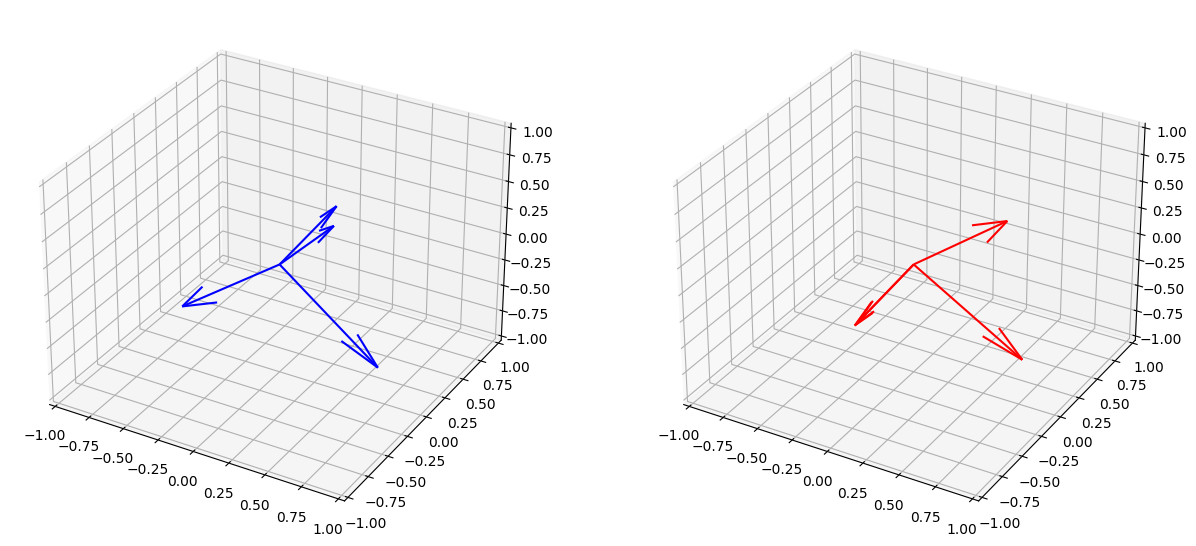

In [187]:
# Plot Eigenvectors into 3d space(excludes first element)
origin = np.array([[0,0,0,0], [0,0,0,0],[0,0,0,0]])
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(221, projection='3d')
ax.quiver(*origin, eigenvectors[:, 0], eigenvectors[:, 1],eigenvectors[:, 2], color='blue')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

# Plot Eigenvectors into 3d space(excludes last element)
bx = fig.add_subplot(222, projection='3d')
bx.quiver(*origin, eigenvectors[:, 1], eigenvectors[:, 2],eigenvectors[:, 3], color='red')
bx.set_xlim([-1, 1])
bx.set_ylim([-1, 1])
bx.set_zlim([-1, 1])

plt.show()

In [188]:
w_dim_manipulated = np.array([*w2[0], 0, 0])

for u, v in zip(eigenvectors, eigenvalues):
  print("inner product: ", np.inner(u, w_dim_manipulated))
  print("eigenvalue: ", v)
  print()

inner product:  1.0296237142555915
eigenvalue:  -2.8419796372475585e-14

inner product:  0.9831934371991609
eigenvalue:  19.99019153636037

inner product:  -0.9848924754603885
eigenvalue:  163.2681868093093

inner product:  0.9654359266490723
eigenvalue:  651.5243011581371



In [189]:
# Calculate pseudo inverse
# pseudo inverse is same as inverse when inversible
fim_inv = np.linalg.pinv(fim_autodiff)
print(fim_inv)

[[ 0.02693159  0.02418511 -0.00013621 -0.00014061]
 [ 0.02418511  0.02469258  0.00039647  0.00040927]
 [-0.00013621  0.00039647  0.00293377  0.00302853]
 [-0.00014061  0.00040927  0.00302853  0.00312635]]


In [190]:
def fisher_score(single_data, label, model):
  p = model.forward(single_data)
  loss = label*torch.log(p) + (1-label)*torch.log(1. - p)
  grads = torch.autograd.grad(loss, [model.w, model.mu], create_graph=True)
  grads_flat = torch.cat([g.view(-1) for g in grads])
  return grads_flat

def phi(X, label, model, I_inv):
  return I_inv @ fisher_score(X, label, model).detach().cpu().numpy()

def transform(X, eigenvectors):
  return np.linalg.solve(eigenvectors, X)

In [191]:
sample_phi = phi(data1[0], 1, model2, fim_inv)
print(transform(sample_phi, eigenvectors))

[-1.99166443e-20  7.27525019e-05  3.57054088e-06  2.37198626e-06]


In [192]:
mx_coef = [0, 0, 0, 0]
for i in range(4):
  for x in data1:
    mx_coef[i] = max(mx_coef[i], abs(transform(phi(x, 1, model2, fim_inv), eigenvectors)[i]))
  for x in data2:
    mx_coef[i] = max(mx_coef[i], abs(transform(phi(x, 0, model2, fim_inv), eigenvectors)[i]))
print(mx_coef)

[8.799929557165794e-18, 0.030802020064761255, 0.013511867695102457, 0.008623409269129242]


In [193]:
coef_abs_sum = [0, 0, 0, 0]
for i in range(4):
  for x in data1:
    t = transform(phi(x, 1, model2, fim_inv), eigenvectors)[i]
    coef_abs_sum[i] += abs(t)
  for x in data2:
    t = transform(phi(x, 0, model2, fim_inv), eigenvectors)[i]
    coef_abs_sum[i] += abs(t)
print(coef_abs_sum)

[5.401475681769195e-16, 1.9592873819028698, 1.0422026089290701, 0.4762610976308657]


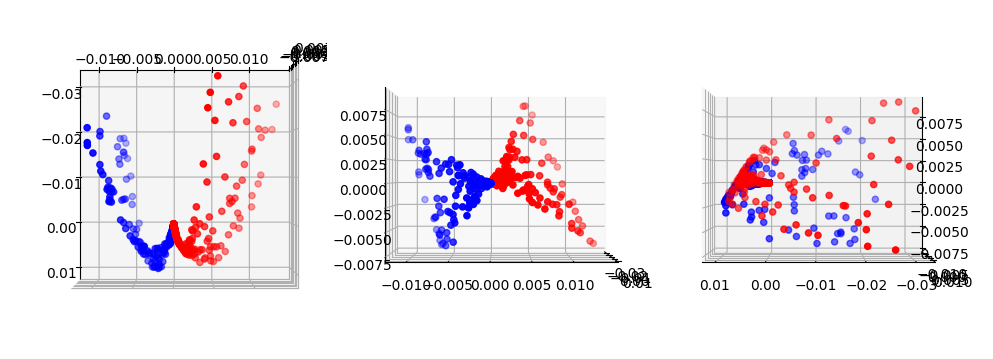

In [194]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(321, projection='3d')
y1 = torch.Tensor([transform(phi(x, 1, model2, fim_inv), eigenvectors) for x in data1])[:, 1:]
y2 = torch.Tensor([transform(phi(x, 0, model2, fim_inv), eigenvectors) for x in data2])[:, 1:]
ax.scatter(y1[:, 0], y1[:, 1], y1[:, 2], color='red')
ax.scatter(y2[:, 0], y2[:, 1], y2[:, 2], color='blue')
ax.view_init(90, 0, 0)

bx = fig.add_subplot(322, projection='3d')
bx.scatter(y1[:, 0], y1[:, 1], y1[:, 2], color='red')
bx.scatter(y2[:, 0], y2[:, 1], y2[:, 2], color='blue')
bx.view_init(0, 90, 0)


cx = fig.add_subplot(311, projection='3d')
cx.scatter(y1[:, 0], y1[:, 1], y1[:, 2], color='red')
cx.scatter(y2[:, 0], y2[:, 1], y2[:, 2], color='blue')
cx.view_init(0, 0, 0)
plt.draw()